In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import dask.dataframe as dd
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Input, Flatten, Dot, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [3]:
user_embeddings = np.load("user_embeddings_layer.npy")

In [4]:
movie_embeddings = np.load("movie_embeddings_layer.npy")

In [5]:
user_embeddings.shape

(200949, 5)

In [ ]:
# Método del codo para KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []
silhouettes = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding_reduced)
    distortions.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(embedding_reduced, kmeans.labels_))

# Graficar los resultados
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), distortions, marker='o', label='Inertia')
plt.title("Método del codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inertia")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouettes, marker='o', label='Silhouette Score')
plt.title("Silhouette Score para KMeans")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()


Silhouette Score (HDBSCAN): -0.3378097414970398
K=2, Silhouette Score=0.3406
K=3, Silhouette Score=0.2758
K=4, Silhouette Score=0.2442
K=5, Silhouette Score=0.2225
K=6, Silhouette Score=0.2183
K=7, Silhouette Score=0.1940
K=8, Silhouette Score=0.2005
K=9, Silhouette Score=0.1903


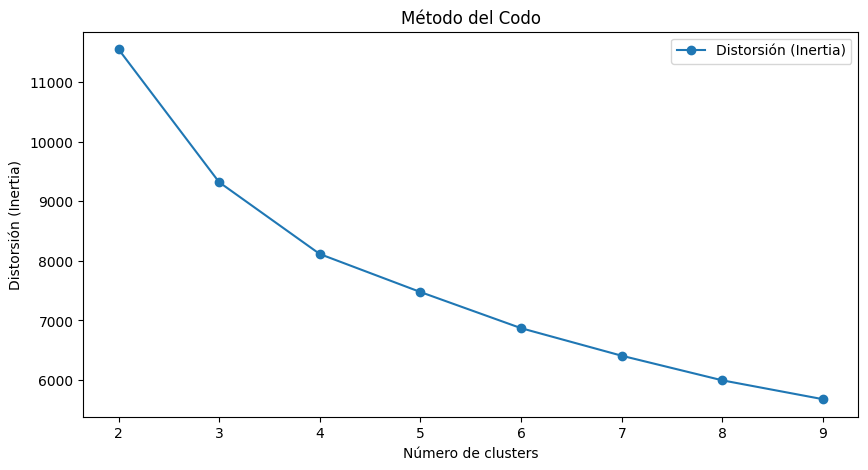

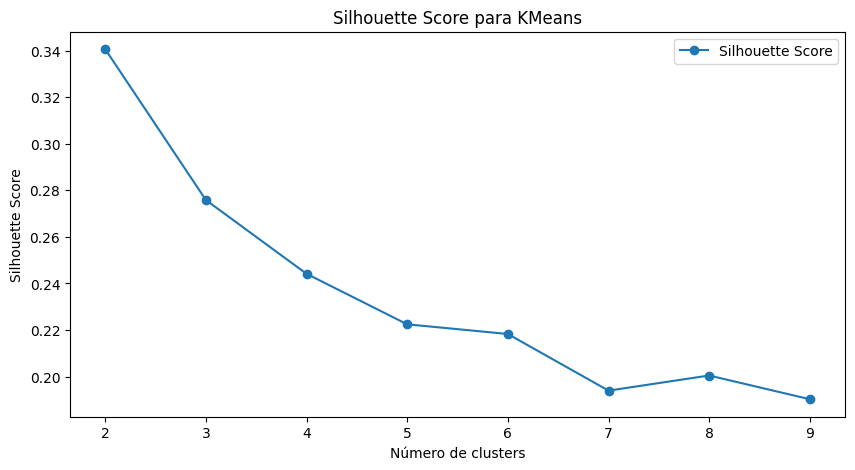

c:\Users\Luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


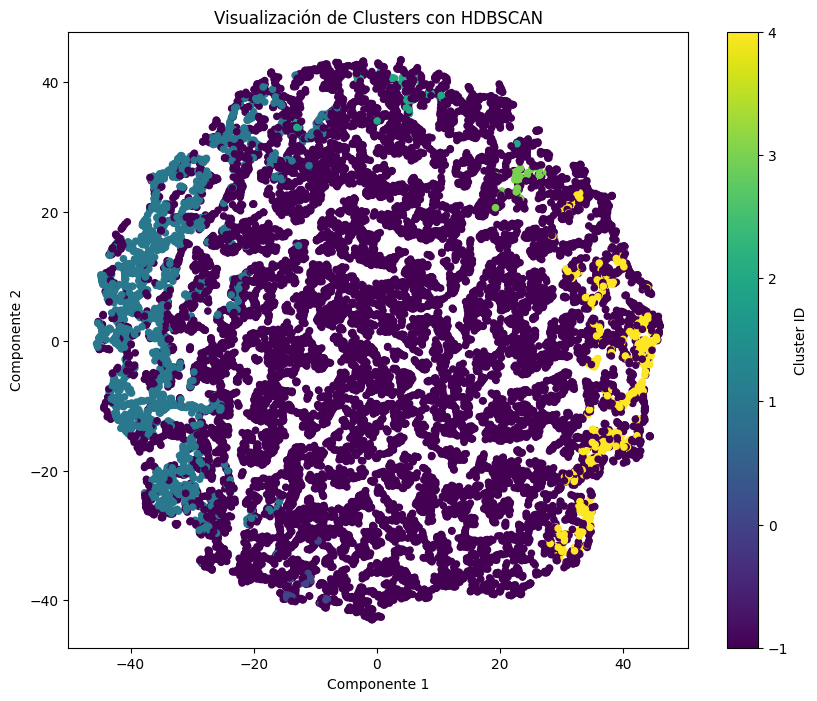

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# ===========================================
# MUESTRA REPRESENTATIVA
# ===========================================
sample_size = int(0.10 * len(user_embeddings))  # Tomamos el 10% del dataset.
np.random.seed(42)  # Control de aleatoriedad
sample_indices = np.random.choice(user_embeddings.shape[0], sample_size, replace=False)
embedding_sampled = user_embeddings[sample_indices]

# ===========================================
# NORMALIZACIÓN DE LOS EMBEDDINGS
# ===========================================
embedding_normalized = normalize(embedding_sampled, norm="l2")

# ===========================================
# CLUSTERING CON HDBSCAN
# ===========================================
hdbscan = HDBSCAN(metric="cosine", min_cluster_size=50, min_samples=10)
hdbscan.fit(embedding_normalized)

# ===========================================
# REDUCCIÓN DE DIMENSIONALIDAD Y VISUALIZACIÓN
# ===========================================
# Verificar el máximo número de componentes permitidos
max_components = min(embedding_normalized.shape[0], embedding_normalized.shape[1])

# Aplicar PCA con el número permitido de componentes
pca = PCA(n_components=min(10, max_components))  # Máximo de 10 o lo permitido
embedding_reduced = pca.fit_transform(embedding_normalized)

# ===========================================
# KMeans Clustering
# ===========================================
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(embedding_reduced)

# ===========================================
# Evaluación del Clustering
# ===========================================
# Silhouette Score para HDBSCAN
silhouette_hdbscan = silhouette_score(embedding_normalized, hdbscan.labels_)
print(f"Silhouette Score (HDBSCAN): {silhouette_hdbscan}")

# Listas para el método del codo y Silhouette Score
distortions = []
silhouettes = []

# Probar KMeans para diferentes valores de k
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding_reduced)
    distortions.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(embedding_reduced, kmeans.labels_))
    print(f"K={k}, Silhouette Score={silhouettes[-1]:.4f}")

# ===========================================
# Gráficos
# ===========================================
# Método del Codo
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), distortions, marker='o', label='Distorsión (Inertia)')
plt.title("Método del Codo")
plt.xlabel("Número de clusters")
plt.ylabel("Distorsión (Inertia)")
plt.legend()
plt.show()

# Silhouette Score para KMeans
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouettes, marker='o', label='Silhouette Score')
plt.title("Silhouette Score para KMeans")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Visualización de HDBSCAN
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
embedding_2d = tsne.fit_transform(embedding_normalized)

plt.figure(figsize=(10, 8))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=hdbscan.labels_,
    cmap="viridis",
    s=20
)
plt.colorbar(label="Cluster ID")
plt.title("Visualización de Clusters con HDBSCAN")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()



In [16]:
set(hdbscan.labels_)

{-1, 0, 1, 2, 3, 4}

In [17]:
import pandas as pd

CONCLUSIÓN:

Luego de los 2 métodos utilizadas para clusterizar a los usuarios y así agruparlos a través de un algoritmo, podemos decir que
el mejor resultado se obtuvo después de entrenar el modelo, es el de determinar el número de clusters con el ¨Método del Codo¨ para luego aplicar Kmeans como la información que se obtiene a continuación. La distribución que muestras indica que los usuarios se han agrupado en 9 clusters (0-8) con un tamaño razonablemente balanceado. Esto es positivo, ya que clusters extremadamente desbalanceados cómo el de  HSDB en donde la mayoría son outliers! podría ser una señal de que el modelo no está capturando bien las características distintivas.

In [19]:
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print(cluster_counts)

7    2897
0    2801
1    2720
3    2371
4    2245
5    2003
2    1917
6    1911
8    1229
Name: count, dtype: int64


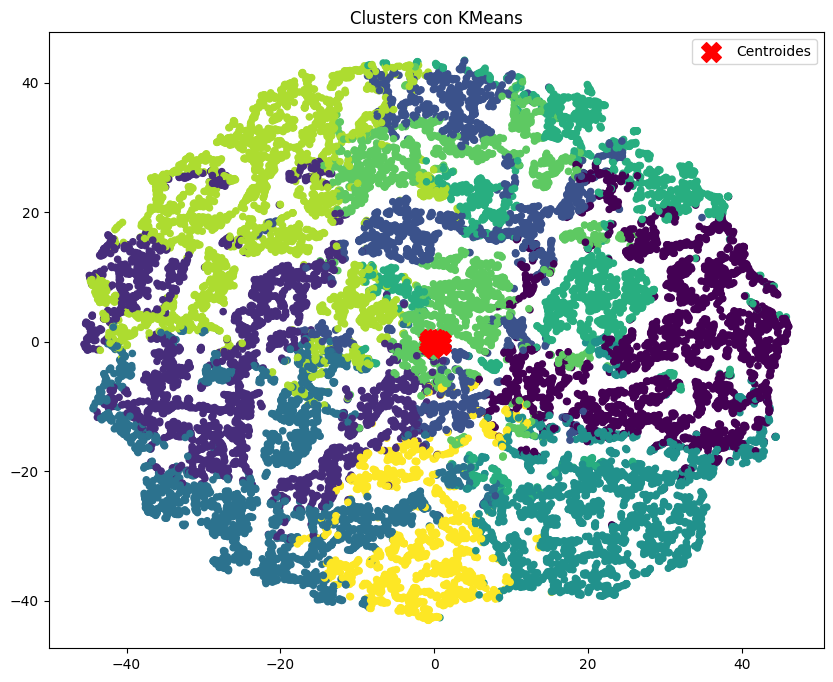

In [20]:

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters con KMeans")
plt.legend()
plt.show()


In [21]:
# Mostrar qué usuarios pertenecen a qué cluster
clustered_users = pd.DataFrame({'user_id': sample_indices, 'cluster': kmeans.labels_})
print(clustered_users.groupby('cluster').count())


         user_id
cluster         
0           2801
1           2720
2           1917
3           2371
4           2245
5           2003
6           1911
7           2897
8           1229


c:\Users\Luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


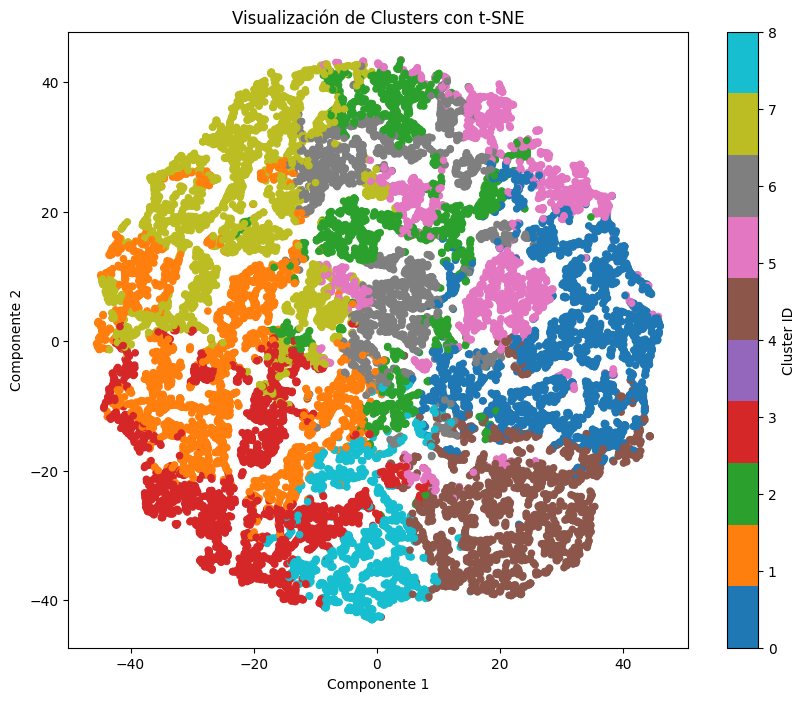

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE



# Realizamos la reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
embedding_2d = tsne.fit_transform(embedding_normalized)

# Crear el gráfico con colores personalizados para cada cluster
plt.figure(figsize=(10, 8))

# Utilizando un mapa de colores 'tab10', que tiene 10 colores distintos
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=kmeans.labels_,  # Las etiquetas de los clusters de KMeans
    cmap="tab10",  # Se usa un mapa de colores con colores bien diferenciados
    s=20  # Tamaño de los puntos
)

# Añadir barra de colores para indicar el Cluster ID
plt.colorbar(label="Cluster ID")

# Títulos y etiquetas del gráfico
plt.title("Visualización de Clusters con t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

# Mostrar el gráfico
plt.show()



In [23]:
# Ver los centros de los clusters
cluster_centers = kmeans.cluster_centers_
print(cluster_centers)


[[ 0.83887845  0.06297086  0.15828831 -0.03643723 -0.00322708]
 [-0.7291794   0.00142689  0.23309816 -0.00649603 -0.00311242]
 [ 0.05536281  0.38890755  0.14801972 -0.43044353  0.0103978 ]
 [-0.7364475  -0.42914766 -0.24698877 -0.00241713 -0.00099792]
 [ 0.8234268  -0.57018197 -0.1479665   0.02440759 -0.00787441]
 [ 0.4731711   0.33166853 -0.40830666  0.08969001  0.00855163]
 [ 0.08053516  0.38445303  0.353405    0.30791897 -0.00606699]
 [-0.4924716   0.36982855 -0.22352324  0.05275223 -0.00295248]
 [-0.20235318 -0.8948332   0.28376633 -0.02099581  0.01676258]]


CONCLUSIÓN:

Luego de los 2 métodos utilizadas para clusterizar a los usuarios y así agruparlos a través de un algoritmo, podemos decir que
el mejor resultado se obtuvo después de entrenar el modelo, es el de determinar el número de clusters con el ¨Método del Codo¨ para luego aplicar Kmeans como la información que se obtiene a continuación. La distribución que muestras indica que los usuarios se han agrupado en 9 clusters (0-8) con un tamaño razonablemente balanceado. Esto es positivo, ya que clusters extremadamente desbalanceados cómo el de  HSDB en donde la mayoría son outliers! podría ser una señal de que el modelo no está capturando bien las características distintivas.